## Regridding PACE and EMIT Data
Adapted from oci_grid_match.ipynb tutorial on Help Hub.

Author: Skye Caplan (NASA, SSAI)

Last updated: 10/24/2025

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html

## Summary

This notebook will use the data downloaded from `colocate_pace_emit.ipynb` and the `rasterio` and `rioxarray` packages to regrid PACE and EMIT data. We will use tools from LPDAAC's VITALS tutorials to orthorectify the data, and then place PACE granules on that grid at OCI's coarser resolution (or we'll try to do this!). We can then intercompare spectra between the two sensors. 

## Learning Objectives

At the end of this notebook, you will know how to:
- Open and orthorectify an EMIT granule
- Put PACE OCI data on EMIT's grid
- Compare spectra (if this is useful...)

## Contents
1. [Setup](#1.-Setup)
2. [Get EMIT Grid](#2.-Get-EMIT-Grid)
3. [Gridding PACE Data](#3.-Gridding-PACE-Data)


## 1. Setup

Begin by importing all of the packages used in this notebook.

In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import rioxarray as rio
import rasterio 
import cf_xarray 
import utils 
import emit_tools as et 

# These are local paths from the first tutorial, can always add a 
emit_paths = ["data/EMIT_L2A_RFL_001_20250117T041501_2501702_015.nc", 
              "data/EMIT_L2A_RFL_001_20250117T041449_2501702_014.nc"]
oci_path = "data/PACE_OCI.20250117T044314.L2.SFREFL.V3_1.nc"

In [2]:
emit1 = et.emit_xarray(emit_paths[0], ortho=True, )
emit2 = et.emit_xarray(emit_paths[1], ortho=True, )
oci = utils.open_oci(oci_path)

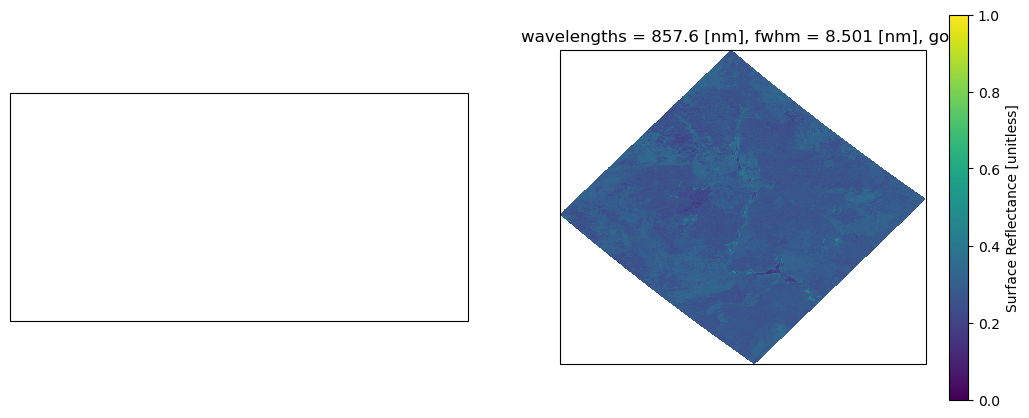

In [3]:
fig, ax =plt.subplots(1,2, figsize=(13,5), 
                    subplot_kw=dict(projection=ccrs.PlateCarree()))
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax[1], transform=ccrs.PlateCarree())
plt.show()

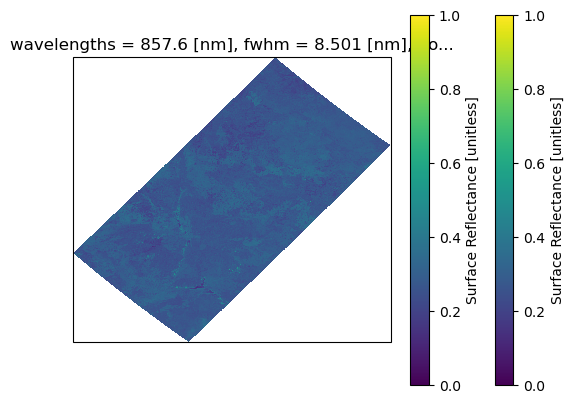

In [4]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
emit1.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax, transform=ccrs.PlateCarree())
emit2.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, ax=ax, transform=ccrs.PlateCarree())
plt.show()

In [5]:
emit1.rio.transform()

Affine(0.0005422325202563637, 0.0, 128.984369018503,
       0.0, -0.0005422325202563676, -27.5614605262285)

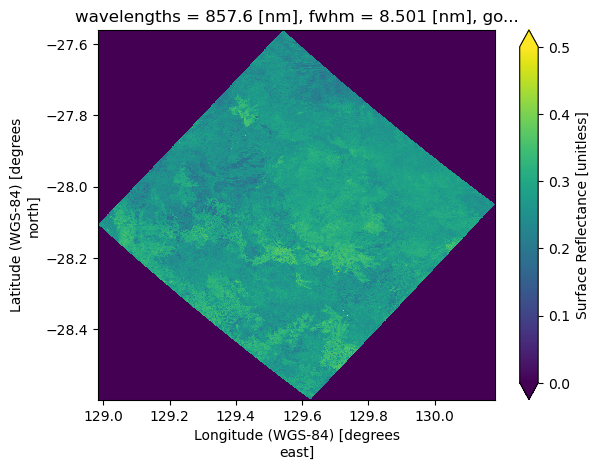

In [8]:
ortho.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=0.5)